## Jump to the related section -- do not execute sequentially

### Create text representation for bag of words model

In [ ]:
import pickle
train_explicit = pickle.load(open('./data/train_explicit.pcl', 'rb'))
train_all = pickle.load(open('./data/train_all.pcl', 'rb'))
test_submission = pickle.load(open('./data/test_submission.pcl', 'rb'))

In [ ]:
train = train_explicit
train.info()

In [ ]:
train = train.fillna("")

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['combined', 'rating'])

In [ ]:
df['combined'] = train['Book-Title'] + " " + train['Book-Author'] + " " + \
                train['Year-Of-Publication'].map(str) + " " + train['Publisher'] + " " + \
                train['Location'] + " " + train['Age'].map(str)
df['rating'] = train['Rating']

In [ ]:
print len(df), " / ", len(train)

In [ ]:
X = df['combined'].values
y = df['rating'].values
#item_count = len(train.BookID.unique())
#user_count = len(train.UserID.unique())

### Create ID representation

In [1]:
import pickle
train_explicit = pickle.load(open('./data/id-based/train_explicit_m.pcl', 'rb'))
train_all = pickle.load(open('./data/id-based/train_all_m.pcl', 'rb'))
#test_submission = pickle.load(open('./data/id-based/test_submission_m.pcl', 'rb'))

In [2]:
train = train_explicit[train_explicit.Rating != 55].sample(frac=1)
test = train_explicit[train_explicit.Rating == 55]
print len(train), " , ", len(test)
item_count = len(train_explicit.BookID.unique())
user_count = len(train_explicit.UserID.unique())

223376  ,  400


In [3]:
train = train_all[train_all.Rating != 55].sample(frac=1)
test = train_all[train_all.Rating == 55]
print len(train), " , ", len(test)
item_count = len(train_all.BookID.unique())
user_count = len(train_all.UserID.unique())

612386  ,  400


### Deep Neural Net

In [4]:
from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Merge, Flatten, Dense, Activation, Embedding

Using TensorFlow backend.


In [5]:
X = train[['book_id', 'user_id']].values
y = train['Rating'].values

In [ ]:
#y = y / 10

In [ ]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [6]:
model_left = Sequential()
model_left.add(Embedding(item_count, 50, input_length=1))
model_right = Sequential()
model_right.add(Embedding(user_count, 50, input_length=1))
model = Sequential()
model.add(Merge([model_left, model_right], mode='concat'))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adadelta')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [7]:
model.fit([X[:,0].reshape((len(X),1)), X[:,1].reshape((len(X),1))],
          y,
          batch_size=10000,
          epochs=40,
          validation_split=0.1)

Train on 551147 samples, validate on 61239 samples
Epoch 1/40
551147/551147 [==============================] - 15s - loss: 59.0968 - val_loss: 34.3804

In [8]:
X_test = test[['book_id', 'user_id']].values
prediction = model.predict([X_test[:,0].reshape((len(X_test),1)),
                            X_test[:,1].reshape((len(X_test),1))])

In [9]:
import pandas as pd
test['Prediction'] = pd.Series(prediction.reshape(1,len(test))[0], index=test.index)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
test.head()

,UserID,BookID,BookID_org,user_id,book_id,Rating,Prediction
612386,127208,155553354X,155553354X,41536,232625,55.0,6.275641
612387,127208,0886779758,886779758,41536,24740,55.0,6.059952
612388,127208,1555540139,1555540139,41536,232626,55.0,6.084450
612389,127208,0886777844,886777844,41536,9821,55.0,6.175062
612390,128065,0345347536,345347536,41537,13976,55.0,8.865338


In [11]:
test[['UserID', 'BookID_org', 'Prediction']].to_csv('./submission_dnn.csv', index=False)

### Visualization

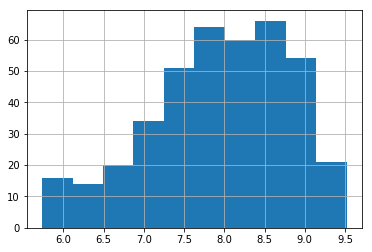

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
test['Prediction'].hist()